# COVID-19: Daily New Confirmed Cases & Projections

In [1]:
import requests, csv, re, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import date, timedelta
from hampel import hampel
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from darts.utils.statistics import check_seasonality, plot_acf, extract_trend_and_seasonality, remove_seasonality, remove_trend, plot_residuals_analysis, plot_acf, stationarity_tests, stationarity_test_adf
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.metrics import r2_score, mape, mase, rmse, rmsle, coefficient_of_variation
from darts.models import MovingAverage, KalmanFilter, ExponentialSmoothing, ARIMA, StatsForecastAutoARIMA, LinearRegressionModel
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant

import geopy.geocoders
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("deep")

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import logging
logging.disable(logging.CRITICAL)

__author__ = '(BSD 2-Clause License)'
%matplotlib inline

## Population Center

In [2]:
# homeLoc = (20.86399628, -156.5689097)        ## Maui, Hawaii, US, POP:   167,417
# homeLoc = (36.21458855, -115.0130241)        ## Clark, Nevada, US, POP: 2,266,715
# homeLoc = (34.59933926, -112.5538588)        ## Yavapai, Arizona
# homeLoc = (38.68278902, -121.90182879999999) ## Yolo, California, US, POP:   220,500
# homeLoc = (38.50735751, -122.33283899999999) ## Napa, California, US, POP:  137,744
homeLoc = (37.42288, -122.32755)             ## San Mateo, California, US, POP:   766,573
# homeLoc = (37.177123, -122.366529)           ## SMC, (this location excludes Alameda Co at 40 miles)
# homeLoc = (37.23104908, -121.6970462)        ## Santa Clara, California, US
# homeLoc = (37.64629437, -121.8929271)        ## Alameda, California, US
# homeLoc = (36.21862405,-121.24133970000001)  ## Monterey, California, US
# homeLoc = (29.88548725, -96.27736949)        ## Austin, Texas, US, POP:  30,032
# homeLoc = (31.31925973, -95.42226208)        ## Houston, Texas
# homeLoc = (34.65329488, -120.0188492)        ## Santa Barbara, California
# homeLoc = (34.30828379, -118.2282411)        ## Los Angeles, California
# homeLoc = (39.01002188, -94.34724536)        ## Jackson, Missouri
# homeLoc = (38.77965956, -120.5233166)        ## El Dorado, California
# homeLoc = (40.7672726,-73.97152637)          ## New York, New York
# homeLoc = (25.6112362,-80.55170587)          ## Miami-Dade, Florida

In [3]:
distTH = 60   ## miles from homeLoc
popMult = 1e5 ## 100k
startDate = pd.Timestamp('20200301')
endNdaysBack = 0

backtestRatio = 0.9
backtestStride = 3
forecastHorizon = 7
predictionDays = 90

geopy.geocoders.options.default_timeout = 15
geolocator = Nominatim(user_agent="revLookup")
location = geolocator.reverse(query=homeLoc, zoom=9)
citations = '''Ground truth: Johns Hopkins University. “COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE).” https://github.com/CSSEGISandData/COVID-19. Accessed {}.
Population center: {}
Copyright © {} {}'''.format(date.today().strftime('%-d %b %Y'), location.address, date.today().year, __author__)

In [4]:
def getCounties(data):
    countyList = []
    covid19Data = []
    populationSum = 0
    for row in data:
        fips = row['FIPS']
        if re.match(r'[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', fips):  ## match floats
            fips = float(fips)
            combinedKey = row['Combined_Key']
            lat = row['Lat']
            long_ = row['Long_']
#             try:
            countyLoc = (float(lat), float(long_))
#             except Exception:
#                 print("Error: >>> {}, {} <<<".format(lat, long_))
#                 pass
            distance = geodesic(homeLoc, countyLoc).miles
            if distance <= distTH:
                population = populationLookup[fips]
                populationSum += int(population)
                countyList.append(fips)
                print('FIPS:{:7.1f}, {:>30}, POP:{:10,.0f}, {:4,.0f}-miles, {}'.format(fips, combinedKey, float(population), distance, countyLoc))
                covid19Data.append(row)
                if distance <=1:
                    itemList = []
                    for k, v in row.items():
                        itemList.append([k, v])
                    confCaseDays = itemList[11:]
                    k, week2Ago = confCaseDays[-15]
                    k, weekAgo = confCaseDays[-8]
                    k, last = confCaseDays[-1]
                    last = int(float(last))
                    weekAgo = int(float(weekAgo))
                    week2Ago = int(float(week2Ago))
    print('Total population: {:,.0f}'.format(populationSum))
    return(countyList, covid19Data, populationSum)

In [5]:
# FIPS population
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
r = requests.get(url)
if r.status_code != 200:
    # print("Error! Status Code: {}".format(r.status_code))
    raise SystemExit("Error! Status Code: {}".format(r.status_code))

LTable = r.content
data = csv.DictReader(io.StringIO(LTable.decode('utf-8')))

populationLookup = {}
for row in data:
    fips = row['FIPS']
    population = row['Population']
    if re.match(r'[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', fips):  ## match floats
        populationLookup[float(fips)] = population

## Total Population Area

In [6]:
# Daily cases
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
r = requests.get(url)
if r.status_code != 200:
    # print("Error! Status Code: {}".format(r.status_code))
    raise SystemExit("Error! Status Code: {}".format(r.status_code))

confCasesUS = r.content
data = csv.DictReader(io.StringIO(confCasesUS.decode('utf-8')))
counties, covid19Data, populationSum = getCounties(data)
countyCount = len(counties)

FIPS: 6001.0,        Alameda, California, US, POP: 1,671,329,   28-miles, (37.64629437, -121.8929271)
FIPS: 6013.0,   Contra Costa, California, US, POP: 1,153,526,   41-miles, (37.91923498, -121.9289527)
FIPS: 6041.0,          Marin, California, US, POP:   258,826,   50-miles, (38.07122463, -122.7210631)
FIPS: 6075.0,  San Francisco, California, US, POP:   881,549,   24-miles, (37.75215114, -122.4385672)
FIPS: 6081.0,      San Mateo, California, US, POP:   766,573,    0-miles, (37.4228808, -122.32755459999998)
FIPS: 6085.0,    Santa Clara, California, US, POP: 1,927,852,   37-miles, (37.23104908, -121.6970462)
FIPS: 6087.0,     Santa Cruz, California, US, POP:   273,213,   31-miles, (37.05580291, -122.0066524)
Total population: 6,932,868


In [7]:
countyData = []
for row in covid19Data:
    itemList = []
    for k, v in row.items():
        itemList.append([k, v])
    confCaseDays = itemList[11:]
    df = pd.DataFrame(confCaseDays, columns=['Date', 'Cases'])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Cases'] = pd.to_numeric(df['Cases'], errors='ignore')
    df['Cases'] = (df['Cases'] / populationSum) * popMult ## Cases per <popMult>
    countyData.append(df)
last = pd.DataFrame({'A' : []})  ## Empty DataFrame
for df in countyData:
    if last.empty == True:
        last = df
        # print(df)
    else:
        # print(df)
        df = pd.merge_asof(last, df, on='Date', by='Date', tolerance=pd.Timedelta('3d'))
        last = df
df['Ground Total'] = df.sum(numeric_only=True, axis=1)
df = df[['Date', 'Ground Total']]
df = df.set_index('Date')
endDate = pd.Timestamp(df.iloc[[-1]].index[0].date() - timedelta(endNdaysBack))
series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Ground Total', fill_missing_dates=True), fill=0.0).drop_before(startDate - timedelta(1))
numDays = len(series)
df = df.tail(numDays)
series = series.drop_after(endDate)
numDays = len(series)
df = df.head(numDays + 1)

#### Seasonality Test

In [8]:
print('Inspecting seasonality...')
seasonalityDetected = False
for m in range(2, 21):
    is_seasonal, period = check_seasonality(series, m=m, alpha=.05)
    if is_seasonal:
        print('> There is seasonality of order {}.'.format(period))
        seasonalityDetected = True
if seasonalityDetected == False:
    print("> No seasonality detected.")

Inspecting seasonality...
> No seasonality detected.


#### Missing Values

In [9]:
rWindow = 14
dfCopy = df
dfCopy['Ground Diff'] = df['Ground Total'].diff()
# reverse sample every n rows, then reverse back
df = df.iloc[::-rWindow, :]
df = df.iloc[::-1]
df = df.resample('D').mean()
# df['Total Smoothed'] = df['Ground Total'].interpolate(method='linear')
# df['Total Smoothed'] = df['Ground Total'].interpolate(method='akima')
# df['Total Smoothed'] = df['Ground Total'].interpolate(method='cubicspline')
dfCopy['Total Smoothed'] = df['Ground Total'].interpolate(method='polynomial', order=3)
df = dfCopy

### KalmanFilter
# kf = KalmanFilter(dim_x=1, kf=None)
# series = TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Total Smoothed', fill_missing_dates=False)
# kf.fit(series)
# df['Total Smoothed'] = kf.filter(series).pd_series()

### Standard ewm or sma
# df['Total Smoothed'] = df['Ground Total'].ewm(span=rWindow).mean()
# df['Total Smoothed'] = df['Ground Total'].rolling(rWindow, min_periods=1, center=True).mean()

df['Smoothed Diff'] = df['Total Smoothed'].diff()
df['Smoothed Diff'].clip(lower=0, inplace=True)
df['Smoothed Diff'].replace(0, np.nan, inplace=True)

mv = missing_values_ratio(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Smoothed Diff'))
print("Missing values: {:0.2f}%".format(mv * 100))

Missing values: 1.46%


In [10]:
series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Smoothed Diff', fill_missing_dates=True), fill=0.0)
df['Smoothed Diff'] = series.pd_dataframe()
# # STL trend
# (trend, seasonal) = extract_trend_and_seasonality(ts=series, freq=14, model=ModelMode.ADDITIVE, method='STL')
# df['stlTrend'] = trend.pd_dataframe()['0']
# df['stlTrend'].clip(lower=0, inplace=True)
# df['Trend Diff'] = df['stlTrend']
# df.drop('stlTrend', axis=1, inplace=True)
# # Naive trend
# (trend, seasonal) = extract_trend_and_seasonality(ts=series, freq=14, model=ModelMode.ADDITIVE, method='naive')
# df['naiveTrend'] = trend.pd_dataframe()['0']
# df['naiveTrend'].clip(lower=0, inplace=True)

#### Outliers

In [11]:
print("Detecting outliers...")

# print("min.: {}".format(df['Trend Diff'].min()))
# print("max.: {}".format(df['Trend Diff'].max()))
# print("nans: {}".format((df['Trend Diff'].isna().sum())))

hempelWindowSize = 7
outliers = hampel(df['Smoothed Diff'], window_size=hempelWindowSize, n=3, imputation=False)
print("Found {} outliers. Imputing...".format(len(outliers)))
print()
df['New Smoothed Diff'] = hampel(df['Smoothed Diff'], window_size=hempelWindowSize, n=3, imputation=True)
# print(df['Trend Diff'].compare(df['New Trend Diff']))
outlierCount = 0
for i in outliers:
    compOne = df['Smoothed Diff'].iloc[i]
    compTwo = df['New Smoothed Diff'].iloc[i]
    if compOne != compTwo:
        outlierCount += 1
        print("{} {:12.6f}  -> {:12.6f}".format(df['Smoothed Diff'].iloc[[i]].index[0].date(), compOne, compTwo))
    else:
        print("{} {:12.6f}  XX {:12.6f}".format(df['Smoothed Diff'].iloc[[i]].index[0].date(), compOne, compTwo))
df['Smoothed Diff'] = df['New Smoothed Diff']
df['Smoothed Diff'].clip(lower=0, inplace=True)
# print(df['Trend Diff'].compare(df['New Trend Diff']))
df.drop('New Smoothed Diff', axis=1, inplace=True)
print()
print("Done. Imputed {} outliers.".format(outlierCount))

Detecting outliers...
Found 12 outliers. Imputing...

2020-03-01     0.000000  XX     0.000000
2020-03-02     0.000000  XX     0.000000
2020-03-03     0.000000  XX     0.000000
2020-03-04     0.000000  XX     0.000000
2020-03-05     0.000000  XX     0.000000
2020-03-06     0.000000  XX     0.000000
2020-03-07     0.000000  XX     0.000000
2020-03-08     0.000000  XX     0.000000
2020-03-09     0.000000  XX     0.000000
2020-03-10     0.000000  XX     0.000000
2020-03-11     0.000000  XX     0.000000
2020-03-12     0.000000  XX     0.000000

Done. Imputed 0 outliers.


#### Stationarity Test

In [12]:
# Stationarity test
adfTest = stationarity_test_adf(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Smoothed Diff'), maxlag=None, regression='c', autolag='AIC')[1]
if adfTest <= 0.05:
    adfResult = "TRUE"
else:
    adfResult = "FALSE"
print("Stationarity test: {} ({:.4f})".format(adfResult, adfTest))

Stationarity test: TRUE (0.0377)


## Weekly Trend

In [13]:
lastWeekMean = df['Smoothed Diff'].tail(14).head(7).mean()
thisWeekMean = df['Smoothed Diff'].tail(7).mean()
changePercent = ((thisWeekMean - lastWeekMean) / lastWeekMean) * 100
if changePercent > 0:
    changeDirection = "UP"
else:
    changeDirection = "DOWN"
print(">>> Mean trend this week ({:.1f}) compared to last week ({:.1f}) is {} ({:.1f}%) <<<".format(thisWeekMean, lastWeekMean, changeDirection, changePercent))

>>> Mean trend this week (35.2) compared to last week (42.5) is DOWN (-17.2%) <<<


## Daily Cases

In [14]:
# series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Trend Diff', fill_missing_dates=True))
transformer = Pipeline([Scaler(MinMaxScaler(feature_range=(1, df['Smoothed Diff'].min() + df['Smoothed Diff'].max() + 1))), BoxCox(lmbda=None, optim_method='mle')])
seriesTransformed = transformer.fit_transform(series)
df['Transformed Diff'] = seriesTransformed.pd_dataframe()
print(df.drop('Transformed Diff', axis=1).tail(40))

            Ground Total  Ground Diff  Total Smoothed  Smoothed Diff
Date                                                                
2022-04-21  16795.040667    68.240157    16784.536981      21.681228
2022-04-22  16797.132154     2.091487    16807.382107      22.845127
2022-04-23  16798.560134     1.427980    16831.410875      24.028768
2022-04-24  16800.449684     1.889550    16856.643027      25.232152
2022-04-25  16889.720099    89.270414    16883.098305      26.455279
2022-04-26  16892.431819     2.711720    16910.796454      27.698149
2022-04-27  16895.230084     2.798265    16939.757216      28.960762
2022-04-28  16981.009879    85.779796    16970.000334      30.243118
2022-04-29  16983.721600     2.711720    17001.545550      31.545217
2022-04-30  16985.423637     1.702037    17034.412609      32.867059
2022-05-01  16987.226643     1.803006    17068.621252      34.208643
2022-05-02  17104.191224   116.964581    17104.191224      35.569971
2022-05-03  17107.018336     2.827

#### Smoothed Seasonality Test

In [15]:
seriesSmoothed = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Diff', fill_missing_dates=True))
print('Inspecting smoothed seasonality...')
seasonalityDetected = False
for m in range(2, 22):
    is_seasonal, period = check_seasonality(seriesSmoothed, m=m, alpha=.05)
    if is_seasonal:
        print('> There is seasonality of order {}.'.format(period))
        seasonalityDetected = True
if seasonalityDetected == False:
    print("> No seasonality detected.")

Inspecting smoothed seasonality...
> No seasonality detected.


#### Smoothed Stationarity Test

In [16]:
adfTest = stationarity_test_adf(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Diff'), maxlag=None, regression='c', autolag='AIC')[1]
if adfTest <= 0.05:
    adfResult = "TRUE"
else:
    adfResult = "FALSE"
print("Stationarity test: {} ({:.4f})".format(adfResult, adfTest))

Stationarity test: TRUE (0.0103)


In [17]:
### Auto select ARIMA params
# import pmdarima as pm
# m = pm.AutoARIMA(start_p=0, d=None, start_q=0,
#                     max_p=6, max_d=3, max_q=4,
#                     m=1, seasonal=False, stationary=False,
#                     information_criterion='aic', alpha=0.05)
# aaDF = seriesSmoothed.pd_series()
# print('Auto-selecting ARIMA params...')
# m.fit(aaDF)
# # print(m.summary())
# # print(m.model_.aic())
# # print(dir(m.model_))
# arimaParams = m.model_.get_params()['order']
# p, d, q = arimaParams
# print('ARIMA({}, {}, {}) selected.'.format(p, d, q))

## Backtesting

In [18]:
models = [
    ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.NONE, damped=True),
    StatsForecastAutoARIMA(),
#     ARIMA(p, d, q),
#     ARIMA(1, 1, 2),
#     ARIMA(4, 1, 2),
]
backtests = []
for model in models:
    print('Backtesting {}...'.format(model))
    backtests.append(model.historical_forecasts(
                        seriesSmoothed,
                        start=backtestRatio,
                        forecast_horizon=forecastHorizon,
                        overlap_end=False,
                        stride=backtestStride,
                        # last_points_only=True,
                        # retrain=False,
                        # retrain=True,
                        verbose=True
                    )
    )

Backtesting ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.NONE, seasonal_periods=None...


  0%|          | 0/26 [00:00<?, ?it/s]

Backtesting Auto-ARIMA-Statsforecasts...


  0%|          | 0/26 [00:00<?, ?it/s]

## Projections

Forecasting...
Plotting...
Forecasting...
Plotting...


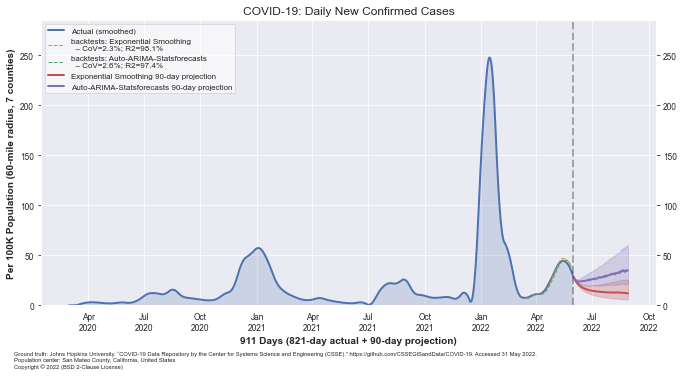

In [19]:
### Set up plot size ratio, ticks, ticklabels
plt.close("all")
sizeRatio = 0.6
fig, ax = plt.subplots()
fig.set_figwidth(16 * sizeRatio)
fig.set_figheight(9 * sizeRatio)
ax.yaxis.set_tick_params(labelright=True)
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))   ## comma separaters
ax.grid(visible=True, which='both', axis='both')

yMax = transformer.inverse_transform(seriesSmoothed).pd_series().max()
ax.set_ylim(0, yMax + (yMax * .15))

transformer.inverse_transform(seriesSmoothed).plot(label='Actual (smoothed)')
for i, m in enumerate(models):
    if re.search(r'NBEATSModel object at ', str(m)):
        m = "N-BEATS"
    elif re.search(r'LGBModel', str(m)):
        m = "LightGBM"
    elif re.search(r'ExponentialSmoothing', str(m)):
        m = "Exponential Smoothing"
    cofv = coefficient_of_variation(backtests[i], seriesSmoothed)
    r2 = r2_score(backtests[i], seriesSmoothed)
    transformer.inverse_transform(backtests[i]).plot(label='backtests: {}\n  – CoV={:.1f}%; R2={:.1f}%'.format(m, cofv, r2 * 100), lw=1, ls='dashed', alpha=0.1)
for i, m in enumerate(models):
    print("Forecasting...")
    m.fit(seriesSmoothed)
    prediction = m.predict(predictionDays, num_samples=25000)
    print("Plotting...")
    if re.search(r'NBEATSModel object at ', str(m)):
        m = "N-BEATS"
    elif re.search(r'LGBModel', str(m)):
        m = "LightGBM"
    elif re.search(r'ExponentialSmoothing', str(m)):
        m = "Exponential Smoothing"
    quantileOffset = .4
    lowQuantile = 0 + quantileOffset
    highQuantile = 1 - quantileOffset
    transformer.inverse_transform(prediction).plot(label='{} {}-day projection'.format(m, predictionDays), low_quantile=lowQuantile, high_quantile=highQuantile)
    
plt.axvline(x=series.time_index[-1].date(), ymin=0, ymax=1, color='k', ls='dashed', lw=2, alpha=0.3)
plt.fill_between(transformer.inverse_transform(seriesSmoothed).pd_series().index, transformer.inverse_transform(seriesSmoothed).pd_series(), label='', lw=2, alpha=0.2)

plt.xlabel(xlabel='{} Days ({}-day actual + {}-day projection)'.format(len(series) + predictionDays, len(series), predictionDays))
plt.ylabel('Per {:d}K Population ({}-mile radius, {} counties)'.format(int(popMult / 1000), distTH, countyCount))
fig.supxlabel(x=0.025, y=0.04, ha='left', va='bottom', weight='light', size='xx-small', t=citations)
plt.legend(prop={'size': 8}, loc='best', frameon=True, fancybox=True, facecolor='#ffffff', framealpha=0.6)

# monthFmt = mdates.DateFormatter("%-d %b %y")
monthFmt = mdates.DateFormatter("%b %Y")
yearFmt = mdates.DateFormatter("%b\n%Y")
nullFmt = mdates.DateFormatter('')

ax.xaxis.set_minor_formatter(monthFmt)
ax.xaxis.set_major_formatter(yearFmt)

months = mdates.MonthLocator()
years = mdates.YearLocator()
autoLoc = mdates.AutoDateLocator()
ax.xaxis.set_minor_locator(autoLoc)
ax.xaxis.set_major_locator(autoLoc)

plt.draw()
ax.set_xticklabels(ax.get_xticklabels(which='both'), rotation=0, ha='center', va='top')
# ax.set_xticklabels(ax.get_xticklabels(minor=True), rotation=0, ha='center', va='top')
# ax.set_xticklabels(ax.get_xticklabels(minor=False), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(which='both'), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha='center', va='top')

plt.title('COVID-19: Daily New Confirmed Cases')
plt.tight_layout()
plt.savefig('covidPlot.png', dpi=600, format='png')
plt.show()